In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import pyodbc
import math
from datetime import datetime
from sqlalchemy import create_engine, exc
from dotenv import load_dotenv

## Calculate Unrealized account balance

In [209]:
server = 'MoemenLaptop'
database = 'InvestmentPortfolio'
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

conn = pyodbc.connect(connection_string)

query = f"""WITH T AS (
	SELECT Symbol, sum(Number_of_Shares) as Shares
	FROM orders
	Where Buy_Sell = 'BUY'
	Group by Symbol
) 
SELECT R.Symbol, [Date], [Close], Shares 
FROM monthly_data as R JOIN T 
		on R.Symbol = T.Symbol""" 

# Use pandas to read the SQL query into a DataFrame
df = pd.read_sql(query, conn)


# Close the connection
conn.close()

df

C:\Users\moeme\AppData\Local\Temp\ipykernel_59416\497704607.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Symbol,Date,Close,Shares
0,AGI,2023-01-01,11.04,1542
1,AGI,2023-02-01,10.18,1542
2,AGI,2023-03-01,12.23,1542
3,AGI,2023-04-01,12.93,1542
4,AGI,2023-05-01,12.34,1542
...,...,...,...,...
121,SPY,2024-02-01,508.08,39
122,SPY,2024-03-01,523.07,39
123,SPY,2024-04-01,501.98,39
124,SPY,2024-05-01,527.37,39


In [210]:
server = 'MoemenLaptop'
database = 'InvestmentPortfolio'
connection_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

conn = pyodbc.connect(connection_string)

query = f"""
	SELECT Date, Symbol, Number_of_Shares as Shares, buy_sell, price
	FROM orders
	Where Buy_Sell = 'SELL' """ 

# Use pandas to read the SQL query into a DataFrame
df2 = pd.read_sql(query, conn)


# Close the connection
conn.close()

C:\Users\moeme\AppData\Local\Temp\ipykernel_59416\1129736058.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query, conn)


In [211]:


# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])

# Iterate through df2 and update df1
for index, row in df2.iterrows():
    sell_date = row['Date']
    symbol = row['Symbol']
    sold_shares = row['Shares']
    
    
    # Subtract sold_shares from df1 where Symbol matches and Date is on or after sell_date
    df.loc[(df['Symbol'] == symbol) & (df['Date'] >= sell_date), 'Shares'] -= sold_shares

print("Updated df")

Updated df


In [212]:
# Calculate the total amount of money per date
df['total_value'] = df['Close'] * df['Shares']

# Group by 'Date' and sum the 'total_value'
total_unrealized = df.groupby('Date')['total_value'].sum().reset_index()

# Rename columns for clarity
total_unrealized.columns = ['Date', 'total_unrealized']

total_unrealized

,Date,total_unrealized
0,2023-01-01,131175.13
1,2023-02-01,109389.38
2,2023-03-01,119608.96
3,2023-04-01,123605.25
4,2023-05-01,115893.41
5,2023-06-01,121952.61
6,2023-07-01,133783.95
7,2023-08-01,120912.83
8,2023-09-01,108358.84
9,2023-10-01,110947.59


## Calculate realized Account balance

In [213]:
df2

,Date,Symbol,Shares,buy_sell,price
0,2023-04-15,AGI,308,SELL,13.31
1,2023-01-10,MARA,838,SELL,4.65
2,2023-01-20,MARA,1257,SELL,6.09
3,2023-05-15,QQQ,11,SELL,349.25
4,2024-05-15,QQQ,16,SELL,456.70
5,2024-01-15,REGN,4,SELL,938.42
6,2024-02-15,SPY,7,SELL,499.68


In [214]:
conn = pyodbc.connect(connection_string)

query = f"""
with x as (
	SELECT date, symbol
	FROM Monthly_Data
),
y as (
	SELECT [Date], Symbol, Number_of_Shares as Shares, price 
	FROM Orders 
	Where Buy_Sell = 'SELL'
)

SELECT x.date, x.symbol, shares, price
From x left join y on x.Symbol = y.Symbol 
				and month(x.date) = month(y.date)
				and year(x.date) = year(y.date) """ 

# Use pandas to read the SQL query into a DataFrame
df3 = pd.read_sql(query, conn)
conn.close()

df3

C:\Users\moeme\AppData\Local\Temp\ipykernel_59416\3913087921.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query, conn)


,date,symbol,shares,price
0,2023-01-01,AGI,NaN,NaN
1,2023-02-01,AGI,NaN,NaN
2,2023-03-01,AGI,NaN,NaN
3,2023-04-01,AGI,308.0,13.31
4,2023-05-01,AGI,NaN,NaN
...,...,...,...,...
122,2024-02-01,SPY,7.0,499.68
123,2024-03-01,SPY,NaN,NaN
124,2024-04-01,SPY,NaN,NaN
125,2024-05-01,SPY,NaN,NaN


In [215]:
df3['total_value'] = df3['price'] * df3['shares']
df3['total_value'] = df3['total_value'].fillna(0)


# Group by 'Date' and sum the 'total_value'
total_realized = df3.groupby('date')['total_value'].sum().reset_index()

# Rename columns for clarity
total_realized.columns = ['date', 'total_value']

# Accumulate the 'Total_value' column
total_realized['total_realized'] = total_realized['total_value'].cumsum()

total_realized = total_realized[['date', 'total_realized']]

total_realized
#df3.tail(50)

,date,total_realized
0,2023-01-01,11551.83
1,2023-02-01,11551.83
2,2023-03-01,11551.83
3,2023-04-01,15651.31
4,2023-05-01,19493.06
5,2023-06-01,19493.06
6,2023-07-01,19493.06
7,2023-08-01,19493.06
8,2023-09-01,19493.06
9,2023-10-01,19493.06


In [216]:
combined_df = pd.concat([total_realized, total_unrealized], axis=1)

combined_df = combined_df[['date', 'total_realized', 'total_unrealized']]

combined_df['total_account'] = combined_df['total_unrealized'] + combined_df['total_realized']
combined_df

,date,total_realized,total_unrealized,total_account
0,2023-01-01,11551.83,131175.13,142726.96
1,2023-02-01,11551.83,109389.38,120941.21
2,2023-03-01,11551.83,119608.96,131160.79
3,2023-04-01,15651.31,123605.25,139256.56
4,2023-05-01,19493.06,115893.41,135386.47
5,2023-06-01,19493.06,121952.61,141445.67
6,2023-07-01,19493.06,133783.95,153277.01
7,2023-08-01,19493.06,120912.83,140405.89
8,2023-09-01,19493.06,108358.84,127851.90
9,2023-10-01,19493.06,110947.59,130440.65


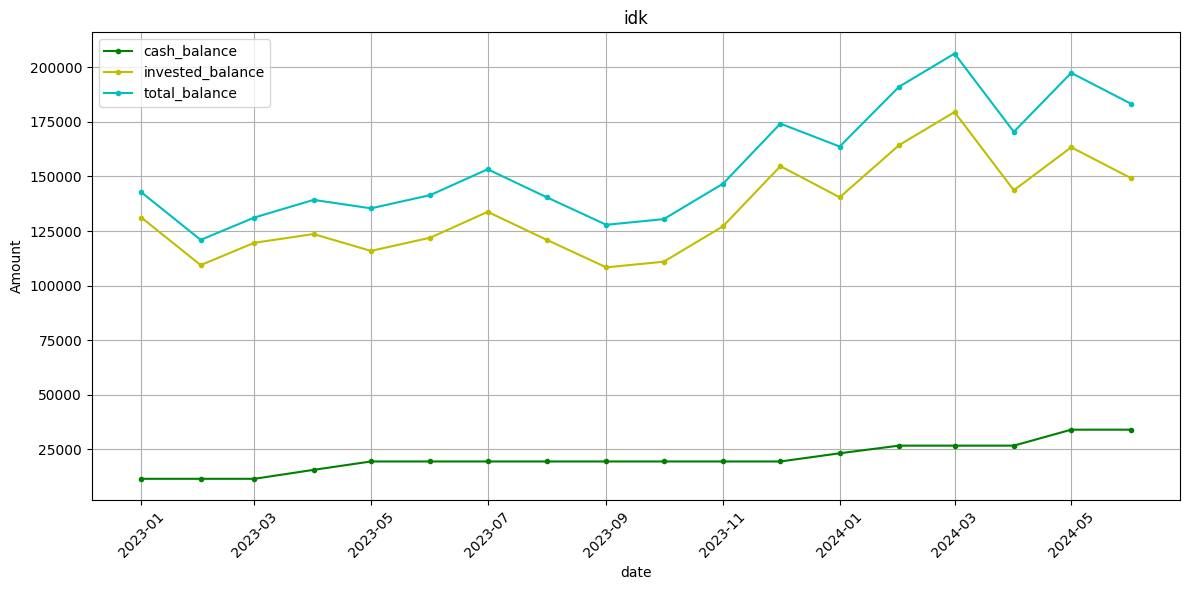

In [217]:
# Create the line plot
plt.figure(figsize=(12, 6))

# Normalize before plotting

# Plot with unique labels
plt.plot(combined_df['date'], combined_df['total_realized'], marker='.', color='g', label=f'cash_balance')
plt.plot(combined_df['date'], combined_df['total_unrealized'], marker='.', color='y', label='invested_balance')
plt.plot(combined_df['date'], combined_df['total_account'], marker='.', color='c', label='total_balance')

# Customize the plot
plt.title('idk')
plt.xlabel('date')
plt.ylabel('Amount')
plt.grid(True)

# Ensure unique legend labels
plt.gca().legend([])
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sharpe


In [218]:
# portfolio return

risk_free_rate = 0.043

position_open = 100000
position_close = combined_df['total_account'].iloc[-1]
periods = combined_df.shape[0]
periods


combined_df['new_col'] = combined_df['total_account'].shift(fill_value=100000)
combined_df['return'] = combined_df['total_account'] - combined_df['new_col']



Rx = ((position_close-position_open)/position_open)*100
Rf = risk_free_rate *100
stdv = combined_df['return'].std()

sharpe_ratio = (Rx-Rf)/stdv

sharpe_ratio


np.float64(0.003917530666866594)

## volatility

In [219]:
volatility = stdv * math.sqrt(periods)

volatility

np.float64(85628.08911043209)